In [107]:
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [108]:
# Dense Layer class
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0., bias_regularizer_l1=0., weight_regularizer_l2=0., bias_regularizer_l2=0.):
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        self.weights = np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1 # lambda
        self.bias_regularizer_l1 = bias_regularizer_l1 # lambda
        self.weight_regularizer_l2 = weight_regularizer_l2 # lambda
        self.bias_regularizer_l2 = bias_regularizer_l2 # lambda

    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = np.dot(self.inputs, self.weights) + self.biases

    def backward(self, dL_dz):
        self.dL_dw = np.dot(self.inputs.T, dL_dz)
        self.dL_db = np.sum(dL_dz, axis=0, keepdims=True)
        self.dL_dX = np.dot(dL_dz, self.weights.T)

        if self.weight_regularizer_l1>0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dL_dw += self.weight_regularizer_l1 * dL1

        if self.bias_regularizer_l1>0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dL_db += self.bias_regularizer_l1 * dL1

        if self.weight_regularizer_l2>0:
            dL2 = 2 * self.weight_regularizer_l2 * self.weights
            self.dL_dw += dL2

        if self.bias_regularizer_l2>0:
            dL2 = 2 * self.bias_regularizer_l2 * self.biases
            self.dL_db += dL2

In [109]:
# ReLU Activation Function
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = np.maximum(0, self.inputs)

    def backward(self, dL_da):
        self.dL_dz = dL_da.copy()
        self.dL_dz[self.inputs <= 0] = 0

In [110]:
# Softmax Activation Function
class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.outputs = probabilities

In [111]:
# General Loss and Categorical Cross Entropy Function
class Loss:
    def regularization_loss(self, layer):
        regularization_loss = 0
        
        # L1 Regularization
        if layer.weight_regularizer_l1>0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
        if layer.bias_regularizer_l1>0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

        # L2 Regularization
        if layer.weight_regularizer_l2>0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
        if layer.bias_regularizer_l2>0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)

        return regularization_loss
    
    def calculate(self, y_pred, y_true):
        neg_log_likelihoods = self.forward(y_pred, y_true)
        avg_loss = np.mean(neg_log_likelihoods)
        return avg_loss

class Loss_CategoricalCrossEntropy(Loss):
    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            correct_predictions = y_pred_clipped[range(len(y_pred_clipped)), y_true]

        if len(y_true.shape) == 2:
            correct_predictions = np.sum(y_pred_clipped*y_true, axis=1)

        neg_log_likelihoods = -np.log(correct_predictions)
        return neg_log_likelihoods

In [112]:
# Combining the Softmax Activation Function and the Categorical Cross Entropy Function
class Actication_Softmax_Loss_Categorical_Cross_Entropy:
    def __init__(self):
        self.activation_softmax = Activation_Softmax()
        self.loss_function = Loss_CategoricalCrossEntropy()

    def forward(self, inputs, y_true):
        self.activation_softmax.forward(inputs)
        self.softmax_outputs = self.activation_softmax.outputs
        self.loss = self.loss_function.calculate(self.softmax_outputs, y_true)
        return self.loss

    def backward(self, y_pred, y_true):
        self.no_of_batches = len(y_pred)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dL_dz = self.softmax_outputs.copy()
        self.dL_dz[range(self.no_of_batches), y_true] -= 1
        self.dL_dz = self.dL_dz/self.no_of_batches

In [126]:
# ADAM Optimizer
class Optimizer_ADAM:
    def __init__(self, learning_rate=.001, decay=0, epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate # alpha
        self.current_learning_rate = learning_rate
        self.decay = decay # learning rate decay factor
        self.epsilon = epsilon # To avoid division by zero
        self.beta_1 = beta_1 # momentum factor
        self.beta_2 = beta_2 # rho: cache memory decay rate
        self.epoch = 0

    def pre_update_params(self):
        self.current_learning_rate = self.learning_rate / 1. + (self.decay * self.epoch)

    def update_params(self, layer):
        if not hasattr(layer, "weight_cache"):
            layer.weight_momentum = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentum = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentum = self.beta_1*layer.weight_momentum + (1-self.beta_1)*layer.dL_dw
        layer.bias_momentum = self.beta_1*layer.bias_momentum + (1-self.beta_1)*layer.dL_db

        layer.weight_cache = self.beta_2*layer.weight_cache + (1-self.beta_2)*(layer.dL_dw**2)
        layer.bias_cache = self.beta_2*layer.bias_cache + (1-self.beta_2)*(layer.dL_db**2)

        layer.weights += -self.current_learning_rate*(layer.weight_momentum/(1-self.beta_1**(self.epoch+1)))/\
                                                   (np.sqrt(layer.weight_cache/(1-self.beta_2**(self.epoch+1))) + self.epsilon)
        layer.biases += -self.current_learning_rate*(layer.bias_momentum/(1-self.beta_1**(self.epoch+1)))/\
                                                   (np.sqrt(layer.bias_cache/(1-self.beta_2**(self.epoch+1))) + self.epsilon)

    def post_update_params(self):
        self.epoch += 1

In [127]:
def preprocess_img(image_path):
    img = Image.open(image_path).convert('L')
    # img = ImageOps.invert(img)
    img = img.resize((28, 28))
    img_array = np.array(img)
    plt.imshow(img_array, cmap="gray")
    plt.show()
    img_array_normalized = img_array / 255.0
    img_array_flattened = img_array_normalized.reshape(1, 784)
    return img_array_flattened

In [128]:
def predict_img(image_path, dense_layer_1, activation_relu_1, dense_layer_2, activation_relu_2, dense_layer_3, softmax_loss):
    processed_img = preprocess_img(image_path)
    
    dense_layer_1.forward(inputs=processed_img)
    activation_relu_1.forward(inputs=dense_layer_1.outputs)
    dense_layer_2.forward(inputs=activation_relu_1.outputs)
    activation_relu_2.forward(inputs=dense_layer_2.outputs)
    dense_layer_3.forward(inputs=activation_relu_2.outputs)
    softmax_loss.forward(inputs=dense_layer_3.outputs, y_true=y_train)

    softmax_outputs = softmax_loss.softmax_outputs
    predictions = np.argmax(softmax_outputs, axis=1)
    
    return predictions[0]

# Loading the dataset

In [116]:
mnist_dataset = fetch_openml('mnist_784', version=1)
X, y = mnist_dataset["data"], mnist_dataset["target"]
print(f"Total number of samples in the MNIST dataset: {len(X)}")
print(f"Dataset shape: {X.shape}")

Total number of samples in the MNIST dataset: 70000
Dataset shape: (70000, 784)


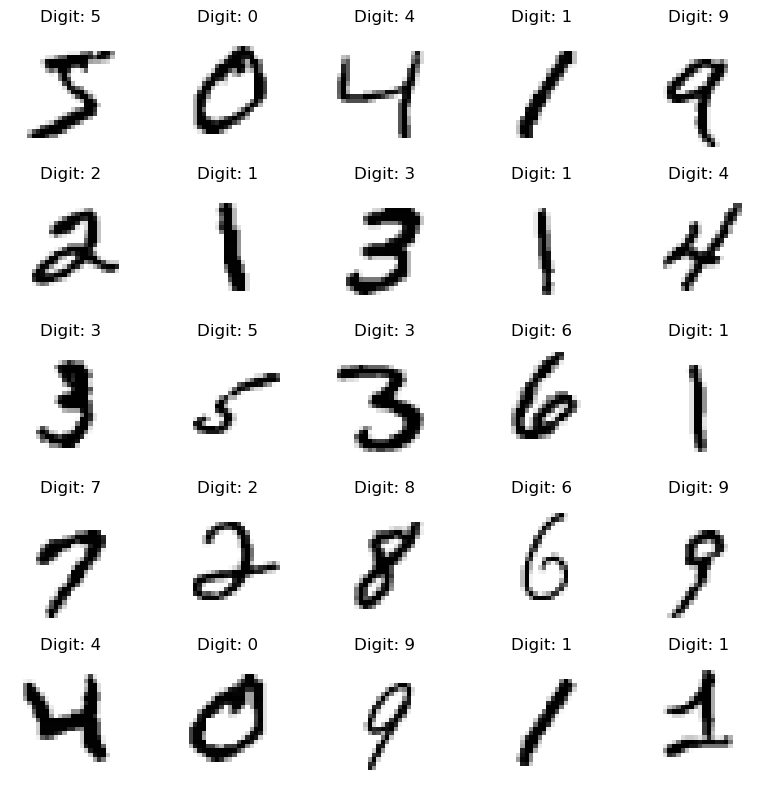

In [117]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i < len(X):
        image_data = X.to_numpy()[i]
        label = y.to_numpy()[i]
        ax.imshow(image_data.reshape(28, 28), cmap='binary')
        ax.set_title(f"Digit: {label}")
        ax.axis('off')

plt.tight_layout()
plt.show()

# Preprocessing the dataset

In [118]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (44800, 784)
Testing data shape: (14000, 784)
Validation data shape: (11200, 784)


In [119]:
# Applying Normalization
X_train = X_train.to_numpy().astype("float32") / 255.0
X_test = X_test.to_numpy().astype("float32") / 255.0
X_val = X_val.to_numpy().astype("float32") / 255.0

In [120]:
y_train = y_train.to_numpy().astype(int)
y_test = y_test.to_numpy().astype(int)
y_val = y_val.to_numpy().astype(int)

# Model Architecture

In [130]:
dense_layer_1 = Layer_Dense(n_inputs=784, n_neurons=128)
activation_relu_1 = Activation_ReLU()
dense_layer_2 = Layer_Dense(n_inputs=128, n_neurons=128)
activation_relu_2 = Activation_ReLU()
dense_layer_3 = Layer_Dense(n_inputs=128, n_neurons=10)
softmax_loss = Actication_Softmax_Loss_Categorical_Cross_Entropy()

adam_optimizer = Optimizer_ADAM(learning_rate=0.02, decay=5e-7)

# Model Training

Epoch: 1, train_accuracy: 0.099, train_loss: 14.494, val_accuracy: 0.118, val_loss: 14.157 lr: 0.0200000
Epoch: 2, train_accuracy: 0.121, train_loss: 14.095, val_accuracy: 0.168, val_loss: 13.299 lr: 0.0200000
Epoch: 3, train_accuracy: 0.176, train_loss: 13.183, val_accuracy: 0.281, val_loss: 11.442 lr: 0.0200005
Epoch: 4, train_accuracy: 0.283, train_loss: 11.432, val_accuracy: 0.415, val_loss: 9.296 lr: 0.0200010
Epoch: 5, train_accuracy: 0.411, train_loss: 9.366, val_accuracy: 0.509, val_loss: 7.778 lr: 0.0200015
Epoch: 6, train_accuracy: 0.505, train_loss: 7.851, val_accuracy: 0.566, val_loss: 6.873 lr: 0.0200020
Epoch: 7, train_accuracy: 0.564, train_loss: 6.906, val_accuracy: 0.604, val_loss: 6.232 lr: 0.0200025
Epoch: 8, train_accuracy: 0.606, train_loss: 6.227, val_accuracy: 0.632, val_loss: 5.809 lr: 0.0200030
Epoch: 9, train_accuracy: 0.635, train_loss: 5.772, val_accuracy: 0.660, val_loss: 5.331 lr: 0.0200035
Epoch: 10, train_accuracy: 0.666, train_loss: 5.245, val_accuracy:

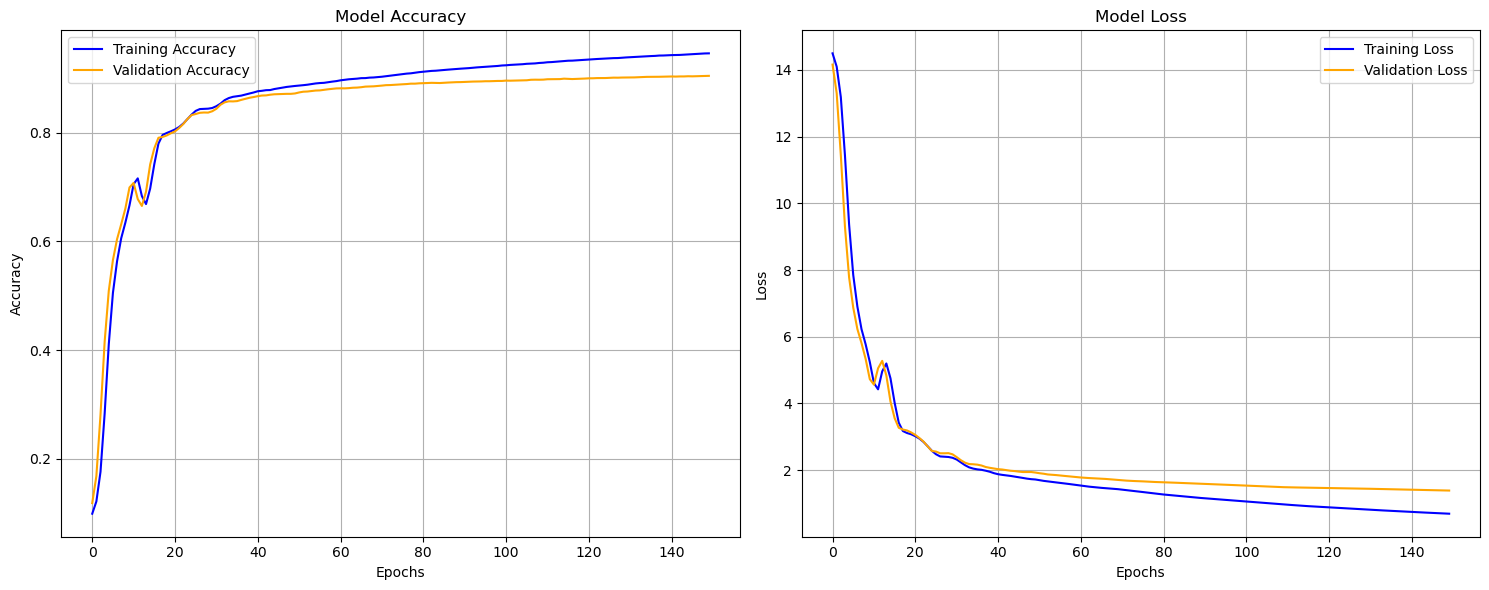

In [131]:
epochs = 150

training_loss_history = []
training_accuracy_history = []

validation_loss_history = []
validation_accuracy_history = []

for epoch in range(epochs):
    # Forward pass
    dense_layer_1.forward(inputs=X_train)
    activation_relu_1.forward(inputs=dense_layer_1.outputs)
    dense_layer_2.forward(inputs=activation_relu_1.outputs)
    activation_relu_2.forward(inputs=dense_layer_2.outputs)
    dense_layer_3.forward(inputs=activation_relu_2.outputs)
    softmax_loss.forward(inputs=dense_layer_3.outputs, y_true=y_train)

    current_learning_rate = adam_optimizer.current_learning_rate

    # Total loss
    data_loss = softmax_loss.loss
    regularization_loss = (
        softmax_loss.loss_function.regularization_loss(dense_layer_1) +
        softmax_loss.loss_function.regularization_loss(dense_layer_2) +
        softmax_loss.loss_function.regularization_loss(dense_layer_3)
    )
    training_loss = data_loss + regularization_loss
    training_loss_history.append(training_loss)
    
    # Accuracy
    predictions = np.argmax(softmax_loss.softmax_outputs, axis=1)
    training_accuracy = np.mean(predictions == y_train)
    training_accuracy_history.append(training_accuracy)

    # Backward pass
    softmax_loss.backward(y_pred=softmax_loss.softmax_outputs, y_true=y_train)
    dense_layer_3.backward(dL_dz=softmax_loss.dL_dz)
    activation_relu_2.backward(dL_da=dense_layer_3.dL_dX)
    dense_layer_2.backward(dL_dz=activation_relu_2.dL_dz)
    activation_relu_1.backward(dL_da=dense_layer_2.dL_dX)
    dense_layer_1.backward(dL_dz=activation_relu_1.dL_dz)

    # Applying ADAM optimizer
    adam_optimizer.pre_update_params()
    adam_optimizer.update_params(dense_layer_1)
    adam_optimizer.update_params(dense_layer_2)
    adam_optimizer.update_params(dense_layer_3)
    adam_optimizer.post_update_params()

    # Forward pass with validation dataset
    dense_layer_1.forward(inputs=X_val)
    activation_relu_1.forward(inputs=dense_layer_1.outputs)
    dense_layer_2.forward(inputs=activation_relu_1.outputs)
    activation_relu_2.forward(inputs=dense_layer_2.outputs)
    dense_layer_3.forward(inputs=activation_relu_2.outputs)
    softmax_loss.forward(inputs=dense_layer_3.outputs, y_true=y_val)

    validation_loss = softmax_loss.loss
    validation_loss_history.append(validation_loss)
    
    predictions = np.argmax(softmax_loss.softmax_outputs, axis=1)
    validation_accuracy = np.mean(predictions == y_val)
    validation_accuracy_history.append(validation_accuracy)
    
    print(f'Epoch: {epoch+1}, train_accuracy: {training_accuracy:.3f}, train_loss: {training_loss:.3f}, val_accuracy: {validation_accuracy:.3f}, val_loss: {validation_loss:.3f} lr: {current_learning_rate:.7f}')

# Testing
dense_layer_1.forward(inputs=X_test)
activation_relu_1.forward(inputs=dense_layer_1.outputs)
dense_layer_2.forward(inputs=activation_relu_1.outputs)
activation_relu_2.forward(inputs=dense_layer_2.outputs)
dense_layer_3.forward(inputs=activation_relu_2.outputs)
softmax_loss.forward(inputs=dense_layer_3.outputs, y_true=y_test)

test_loss = softmax_loss.loss
predictions = np.argmax(softmax_loss.softmax_outputs, axis=1)
test_accuracy = np.mean(predictions == y_test)

print(f"Test accuracy: {test_accuracy:.3f}, Test loss: {test_loss:.3f}")

# Plotting the graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(range(epochs), training_accuracy_history, label='Training Accuracy', color='blue')
ax1.plot(range(epochs), validation_accuracy_history, label='Validation Accuracy', color='orange')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(range(epochs), training_loss_history, label='Training Loss', color='blue')
ax2.plot(range(epochs), validation_loss_history, label='Validation Loss', color='orange')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()